In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

data = pd.read_csv("results.csv")

In [2]:
#Dropping matches without final result
data=data[~data['home_score'].isna()]

data[data["tournament"].str.contains("qualification")]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
1727,1933-06-11,Sweden,Estonia,6.0,2.0,FIFA World Cup qualification,Stockholm,Sweden,False
1732,1933-06-29,Lithuania,Sweden,0.0,2.0,FIFA World Cup qualification,Kaunas,Lithuania,False
1751,1933-09-24,Yugoslavia,Switzerland,2.0,2.0,FIFA World Cup qualification,Belgrade,Yugoslavia,False
1759,1933-10-15,Poland,Czechoslovakia,1.0,2.0,FIFA World Cup qualification,Warsaw,Poland,False
1766,1933-10-29,Switzerland,Romania,2.0,2.0,FIFA World Cup qualification,Berne,Switzerland,False
...,...,...,...,...,...,...,...,...,...
47273,2024-06-11,Saint Kitts and Nevis,Bahamas,1.0,0.0,FIFA World Cup qualification,Basseterre,Saint Kitts and Nevis,False
47274,2024-06-11,Saint Lucia,Aruba,2.0,2.0,FIFA World Cup qualification,Bridgetown,Barbados,True
47275,2024-06-11,Guyana,Belize,3.0,1.0,FIFA World Cup qualification,Bridgetown,Barbados,True
47276,2024-06-11,Dominican Republic,British Virgin Islands,4.0,0.0,FIFA World Cup qualification,San Cristóbal,Dominican Republic,False


In [3]:
continental_championships = ['AFC Asian Cup','African Cup of Nations','UEFA Euro','Copa América','CONCACAF Championship',
                             'Oceania Nations Cup', 'UEFA Nations League', 'World Cup', 'Olympic Games']
continental_qualification=['UEFA Euro qualification','African Cup of Nations qualification','FC Asian Cup qualification', 'FIFA World Cup qualification']


def k_value(tournament):
    """
    Determines the K Factor when calulating team ELO based on tournament.
    """
    k = 10
    if tournament == 'Friendly':
        k = 20
    elif tournament in continental_qualification:
        k = 30
    elif tournament in continental_championships:
        k = 40
    elif tournament == "World Cup":
        k = 50
    return k

def expected_result(home_elo, away_elo):
    """
    Calculates the expected result using home and away team ELO.

    dr: Difference in ratings (home - away)
    We: Win expectancy
    """

    dr = home_elo - away_elo
    # Alternative formula that gives home team advantage
    # dr = (home_elo + 100) - away_elo

    # FIFA uses 600 for divisor and does not incorporate home advantage
    We = 1/(10**(-dr/400) + 1)

    # Return the win expectancy for each team
    return (np.round(We, 3), 1-np.round(We, 3))

def match_result(home_goals, away_goals):
    """
    Actual Match Results
    
    Win = 1,
    Loss = 0,
    Draw = 0.5 for each team
    """

    if home_goals > away_goals:
        w_home = 1
        w_away = 0
    elif away_goals > home_goals:
        w_home = 0
        w_away = 1
    else:
        w_home = 0.5
        w_away = 0.5
    
    return (w_home, w_away)

def goal_index(home_goals, away_goals):
    if abs(home_goals - away_goals) <= 1:
        return 1
    elif abs(home_goals - away_goals) == 2:
        return 1.5
    else:
        return (11 + abs(home_goals - away_goals)) / 8

In [4]:
def calculate_elo(home_elo, away_elo, home_goals, away_goals, tournament):
    k = k_value(tournament)
    w_home, w_away = match_result(home_goals, away_goals)
    we_home, we_away = expected_result(home_elo, away_elo)
    g = goal_index(home_goals, away_goals)

    new_home_elo = home_elo + k*g*(w_home - we_home)
    new_away_elo = away_elo + k*g*(w_away - we_away)

    return new_home_elo, new_away_elo, we_home, we_away
    

In [5]:
teams = set(data['home_team']).union(set(data['away_team']))
current_elo={team: 1300 for team in teams}

for index, row in data.iterrows(): 
    home_team = row["home_team"]
    away_team = row["away_team"]
    home_goals = row["home_score"]
    away_goals = row["away_score"]
    tournament = row["tournament"]

    home_elo = current_elo[home_team]
    away_elo = current_elo[away_team]

    new_home_elo, new_away_elo, we_home, we_away = calculate_elo(home_elo, away_elo, home_goals, away_goals, tournament)

    current_elo[home_team] = new_home_elo
    current_elo[away_team] = new_away_elo

    data.loc[index, "elo_home_after"] = new_home_elo
    data.loc[index, "elo_away_after"] = new_away_elo
    data.loc[index, "elo_home_before"] = home_elo
    data.loc[index, "elo_away_before"] = away_elo
    data.loc[index, "home_probability"] = we_home
    data.loc[index, "away_probability"] = we_away

In [6]:
team_elos = pd.concat([data[["date", "home_team", "elo_home_after"]].rename(
    columns={"home_team":"Team", "elo_home_after": "Elo"}
), data[["date", "away_team", "elo_away_after"]].rename(columns={"away_team": "Team", "elo_away_after": "Elo"})])

team_elos.sort_values(by="date", ascending=False, inplace=True)
team_elos.drop_duplicates("Team", inplace=True)
team_elos.sort_values(by="Elo", ascending=False, inplace=True)
team_elos.reset_index(drop=True, inplace=True)
team_elos["Position"] = team_elos.index + 1

In [7]:
team_elos

,date,Team,Elo,Position
0,2024-06-14,Argentina,1910.74125,1
1,2024-06-15,Spain,1871.21125,2
2,2024-06-12,Brazil,1850.36375,3
3,2024-06-09,France,1811.48375,4
4,2024-06-11,Portugal,1809.24750,5
...,...,...,...,...
331,2024-06-11,Sri Lanka,832.50625,332
332,2024-06-07,Liechtenstein,827.71750,333
333,2023-10-17,Macau,805.80875,334
334,2023-10-17,Timor-Leste,789.73625,335


In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def display_elos(elos, n=15):
    elos.sort_values(by="Elo", ascending=False, inplace=True)

    top_teams = elos.head(n)

    color_map = plt.get_cmap('viridis')
    normalize = colors.Normalize(vmin=min(top_teams["Elo"]), vmax=max(top_teams["Elo"]))
    plot_colors = color_map(normalize(top_teams["Elo"]))

    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_teams["Team"], top_teams["Elo"], color=plot_colors)

    for bar in bars:
        plt.text(
            bar.get_width() + 5,
            bar.get_y() + bar.get_height() / 2,
            f"{bar.get_width():.0f}",
            ha="left",
            va="center",
            fontsize=10
            )


    plt.xlabel("Elo Rating")
    plt.title("Top Teams by Elo Rating")
    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle="--")

    plt.tight_layout()
    plt.show()

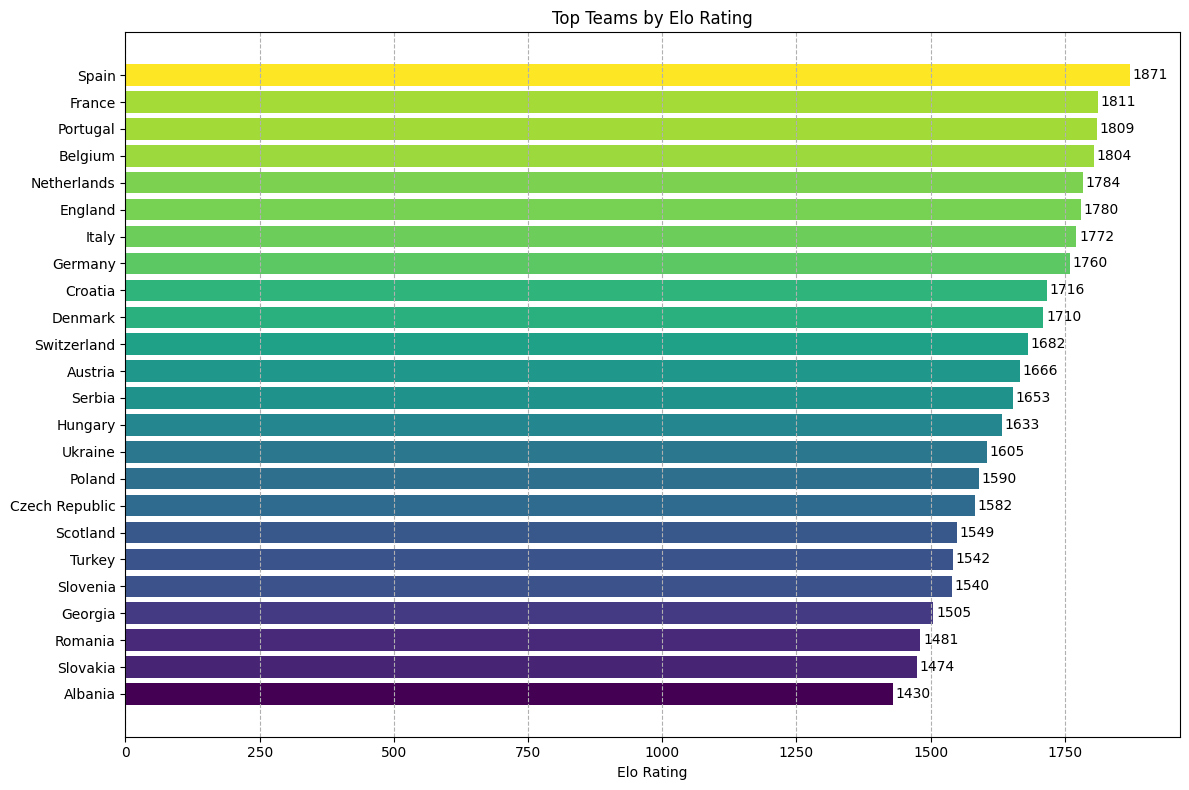

In [9]:
euro_teams =[
    "Albania", "Scotland", "Hungary", "Romania",
    "Germany", "Slovakia", "England", "Czech Republic",
    "Austria", "Slovenia", "Italy", "Serbia",
    "Belgium", "Spain", "Netherlands", "Switzerland",
    "Croatia", "France", "Poland", "Turkey",
    "Denmark", "Georgia", "Portugal", "Ukraine"
]

europe_elos = team_elos[team_elos.Team.isin(euro_teams)].copy()
display_elos(europe_elos, 24)

In [10]:
def calculate_attack_defense(home_attack, away_attack, home_defense, away_defense, home_goals, away_goals, home_elo, away_elo, tournament, neutral):
    # K factor for the tournament played
    k = k_value(tournament)
    # Arbitrary value for home team advantage (can be adjusted)
    c = 1.33 if not neutral else 1

    # Calculate expected goals for home and away
    xg_home = home_attack * away_defense * c
    xg_away = away_attack * home_defense / c 

    # Calculate new attack and defense rating for each team
    new_home_attack = home_attack + (k/2000) * (home_goals - xg_home)
    new_away_attack = away_attack + (k/2000) * (away_goals - xg_away)
    new_home_defense = home_defense + (k/2000) * (away_goals - xg_away)
    new_away_defense = away_defense + (k/2000) * (home_goals - xg_home)

    return new_home_attack, new_away_attack, new_home_defense, new_away_defense, xg_home, xg_away

In [11]:
# Initialize strengths
attack_strength = {team: 1.0 for team in teams}
defense_strength = {team: 1.0 for team in teams}

for index, row in data.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    home_goals = row['home_score']
    away_goals = row['away_score']
    home_elo = row["elo_home_before"]
    away_elo = row["elo_away_before"]
    tournament = row["tournament"]
    neutral_venue = row["neutral"]

    home_attack = attack_strength[home_team]
    away_attack = attack_strength[away_team]
    home_defense = defense_strength[home_team]
    away_defense = defense_strength[away_team]

    new_home_attack, new_away_attack, new_home_defense, new_away_defense, xg_home, xg_away = calculate_attack_defense(
        home_attack, away_attack, home_defense, away_defense, home_goals, away_goals, home_elo, away_elo, tournament, neutral_venue)
    
    attack_strength[home_team] = new_home_attack
    attack_strength[away_team] = new_away_attack
    defense_strength[home_team] = new_home_defense
    defense_strength[away_team] = new_away_defense

    data.loc[index, "home_attack_before"] = home_attack
    data.loc[index, "away_attack_before"] = away_attack
    data.loc[index, "home_attack_after"] = new_home_attack
    data.loc[index, "away_attack_after"] = new_away_attack
    data.loc[index, "home_defense_before"] = home_defense
    data.loc[index, "away_defense_before"] = away_defense
    data.loc[index, "home_defense_after"] = new_home_defense
    data.loc[index, "away_defense_after"] = new_away_defense
    data.loc[index, "xGHome"] = xg_home
    data.loc[index, "xGAway"] = xg_away



In [12]:
ad_frame = data.copy()
ad_frame = pd.concat([data[["date", "home_team", "home_attack_after", "home_defense_after"]].rename(
    columns={"home_team": "Team", "home_attack_after":"Attack Rating", "home_defense_after":"Defense Rating"}
), data[["date", "away_team", "away_attack_after", "away_defense_after"]].rename(
    columns={"away_team": "Team", "away_attack_after": "Attack Rating", "away_defense_after": "Defense Rating"}
)])
ad_frame.sort_values(by='date', ascending=False, inplace=True)
ad_frame.drop_duplicates("Team", inplace=True)
ad_frame.sort_values(by="Defense Rating", ascending=True, inplace=True)
ad_frame.reset_index(drop=True, inplace=True)
ad_frame["Defense Position"] = ad_frame.index + 1
ad_frame.sort_values(by="Attack Rating", ascending=False, inplace=True)
ad_frame.reset_index(drop=True, inplace=True)
ad_frame["Attack Position"] = ad_frame.index + 1

In [13]:
ad_frame.head(10)

,date,Team,Attack Rating,Defense Rating,Defense Position,Attack Position
0,2024-06-12,Brazil,2.810793,0.390134,2,1
1,2024-06-15,Spain,2.712736,0.455002,4,2
2,2024-06-14,Germany,2.636128,0.764789,52,3
3,2024-06-08,Belgium,2.483257,0.575239,15,4
4,2024-06-14,Argentina,2.479147,0.312858,1,5
5,2024-06-11,Japan,2.428894,0.595761,17,6
6,2024-06-10,Netherlands,2.389893,0.656289,28,7
7,2024-06-11,Portugal,2.375318,0.474292,5,8
8,2024-06-09,France,2.269450,0.518069,11,9
9,2024-06-11,Australia,2.218985,0.506707,10,10


In [14]:
def display_attack_defense(elos, n=10):
    elos_by_attack = elos.sort_values(by="Attack Rating", ascending=False).head(n)
    elos_by_defense = elos.sort_values(by="Defense Rating", ascending=True).head(n)
    
    # Color maps for both plots
    attack_colors = plt.cm.viridis(elos_by_attack['Attack Rating'] / max(elos_by_attack['Attack Rating']))
    defense_colors = plt.cm.viridis(elos_by_defense['Defense Rating'] / max(elos_by_defense['Defense Rating']))

    # Create a subplot
    figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(20, 10))

    attack_bars = axis_1.barh(elos_by_attack["Team"], elos_by_attack["Attack Rating"], color=attack_colors)
    axis_1.set_xlabel("Attacking Power", fontsize=14)
    axis_1.set_title("Top Teams by Attacking Power", fontsize=16, weight="bold")
    axis_1.invert_yaxis()
    axis_1.grid(axis="x", linestyle="--")

    for bar in attack_bars:
        axis_1.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
        )

    defense_bars = axis_2.barh(elos_by_defense["Team"], elos_by_defense["Defense Rating"], color=defense_colors)
    axis_2.set_xlabel("Defensive Power", fontsize=14)
    axis_2.set_title("Top Teams by Defensive Power", fontsize=16, weight="bold")
    axis_2.invert_yaxis()
    axis_2.grid(axis="x", linestyle="--")

    for bar in defense_bars:
        axis_2.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
        )

    plt.tight_layout()
    plt.show()

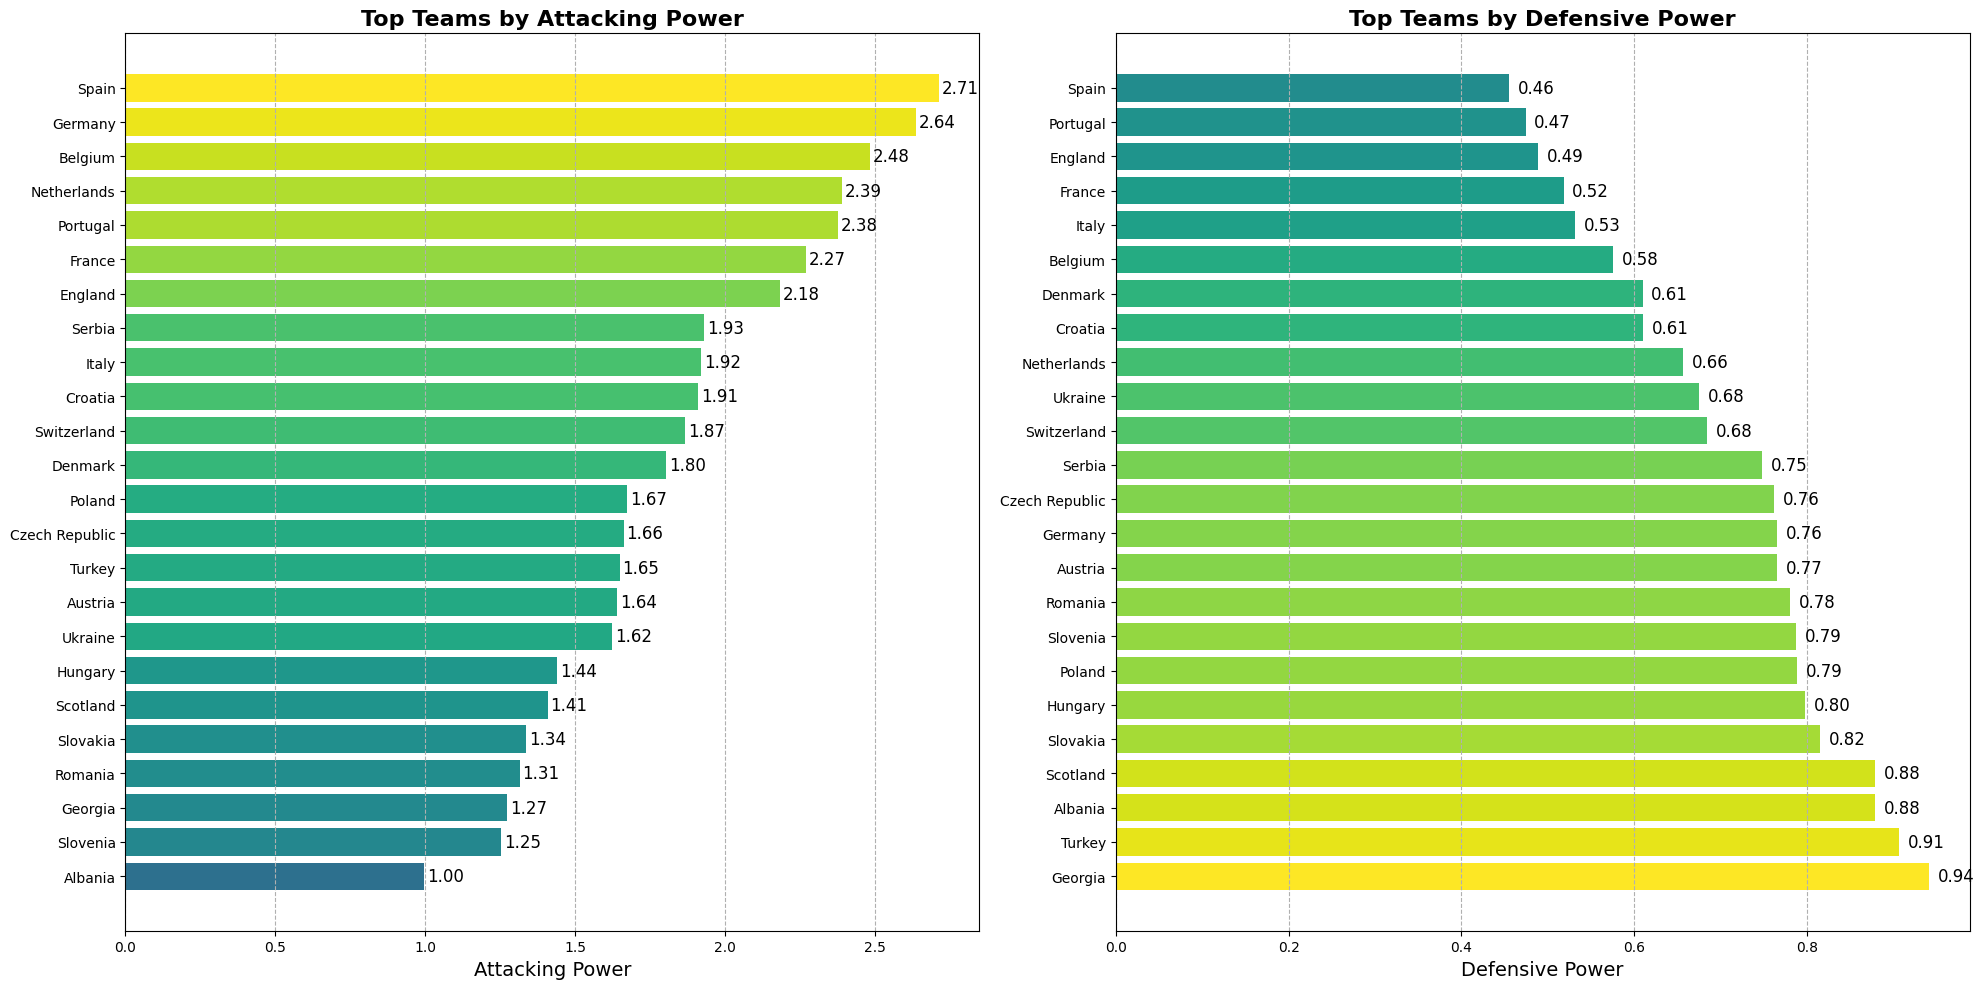

In [15]:
ad_europe_teams = ad_frame[ad_frame.Team.isin(euro_teams)]
display_attack_defense(ad_europe_teams, 24)

In [16]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Prepare features and labels
# We'll use home_elo, away_elo, home_attack, away_attack, home_defense, away_defense as features
data["match_result"] = data.apply(lambda row: 1 if row["home_score"] > row["away_score"] else (0 if row["home_score"] < row["away_score"] else 2), axis=1)

features = data[["elo_home_before", "elo_away_before", "home_attack_before", "away_attack_before", "home_defense_before", "away_defense_before"]]
labels = data["match_result"]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)


In [17]:
# Train XGBoost model
model = xgb.XGBClassifier(n_estimators=125, max_depth=5, learning_rate=0.1, n_jobs=10)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=125, n_jobs=10,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.5715796151406217


In [19]:
matches_data = [
    # Group A
    {"Group": "A", "Home_Team": "Germany", "Away_Team": "Scotland"},
    {"Group": "A", "Home_Team": "Hungary", "Away_Team": "Switzerland"},
    {"Group": "A", "Home_Team": "Germany", "Away_Team": "Hungary"},
    {"Group": "A", "Home_Team": "Scotland", "Away_Team": "Switzerland"},
    {"Group": "A", "Home_Team": "Switzerland", "Away_Team": "Germany"},
    {"Group": "A", "Home_Team": "Scotland", "Away_Team": "Hungary"},
    # Group B
    {"Group": "B", "Home_Team": "Spain", "Away_Team": "Croatia"},
    {"Group": "B", "Home_Team": "Italy", "Away_Team": "Albania"},
    {"Group": "B", "Home_Team": "Croatia", "Away_Team": "Albania"},
    {"Group": "B", "Home_Team": "Spain", "Away_Team": "Italy"},
    {"Group": "B", "Home_Team": "Albania", "Away_Team": "Spain"},
    {"Group": "B", "Home_Team": "Croatia", "Away_Team": "Italy"},
    # Group C
    {"Group": "C", "Home_Team": "Slovenia", "Away_Team": "Denmark"},
    {"Group": "C", "Home_Team": "Serbia", "Away_Team": "England"},
    {"Group": "C", "Home_Team": "Slovenia", "Away_Team": "Serbia"},
    {"Group": "C", "Home_Team": "Denmark", "Away_Team": "England"},
    {"Group": "C", "Home_Team": "England", "Away_Team": "Slovenia"},
    {"Group": "C", "Home_Team": "Denmark", "Away_Team": "Serbia"},
    # Group D
    {"Group": "D", "Home_Team": "Poland", "Away_Team": "Netherlands"},
    {"Group": "D", "Home_Team": "Austria", "Away_Team": "France"},
    {"Group": "D", "Home_Team": "Poland", "Away_Team": "Austria"},
    {"Group": "D", "Home_Team": "Netherlands", "Away_Team": "France"},
    {"Group": "D", "Home_Team": "Netherlands", "Away_Team": "Austria"},
    {"Group": "D", "Home_Team": "France", "Away_Team": "Poland"},
    # Group E
    {"Group": "E", "Home_Team": "Romania", "Away_Team": "Ukraine"},
    {"Group": "E", "Home_Team": "Belgium", "Away_Team": "Slovakia"},
    {"Group": "E", "Home_Team": "Slovakia", "Away_Team": "Ukraine"},
    {"Group": "E", "Home_Team": "Belgium", "Away_Team": "Romania"},
    {"Group": "E", "Home_Team": "Slovakia", "Away_Team": "Romania"},
    {"Group": "E", "Home_Team": "Ukraine", "Away_Team": "Belgium"},
    # Group F
    {"Group": "F", "Home_Team": "Turkey", "Away_Team": "Georgia"},
    {"Group": "F", "Home_Team": "Portugal", "Away_Team": "Czech Republic"},
    {"Group": "F", "Home_Team": "Georgia", "Away_Team": "Czech Republic"},
    {"Group": "F", "Home_Team": "Turkey", "Away_Team": "Portugal"},
    {"Group": "F", "Home_Team": "Georgia", "Away_Team": "Portugal"},
    {"Group": "F", "Home_Team": "Czech Republic", "Away_Team": "Turkey"},
]

# Create a dataframe
matches_data = pd.DataFrame(matches_data)


In [20]:
# Merge elo data
matches_data = matches_data.merge(team_elos, left_on="Home_Team", right_on="Team", suffixes=('', '_home')).drop(columns=["Team", "date"])
matches_data = matches_data.rename(columns={'Elo': 'home_elo'})

matches_data = matches_data.merge(team_elos, left_on="Away_Team", right_on="Team", suffixes=('', '_away')).drop(columns=["Team", "date"])
matches_data = matches_data.rename(columns={'Elo': 'away_elo'})

# Merge attack/defense ratings
matches_data = matches_data.merge(ad_frame, left_on="Home_Team", right_on="Team", suffixes=('', '_home')).drop(columns=["Team", "date"])
matches_data = matches_data.rename(columns={'Attack Rating': 'home_attack', 'Defense Rating': 'home_defense'})

matches_data = matches_data.merge(ad_frame, left_on="Away_Team", right_on="Team", suffixes=('', '_away')).drop(columns=["Team", "date"])
matches_data = matches_data.rename(columns={'Attack Rating': 'away_attack', 'Defense Rating': 'away_defense'})

# Drop duplicate columns again if necessary
matches_data = matches_data.loc[:, ~matches_data.columns.duplicated()]

# Inspect the columns of matches_data after dropping duplicates
# print(matches_data.columns)

# Prepare features for prediction
features_to_predict = matches_data[["home_elo", "away_elo", "home_attack", "away_attack", "home_defense", "away_defense"]].copy()

# Check the columns before renaming
# print(features_to_predict.columns)

# Rename columns to match training feature names
features_to_predict.columns = ["elo_home_before", "elo_away_before", "home_attack_before", "away_attack_before", "home_defense_before", "away_defense_before"]

# Check the columns after renaming
# print(features_to_predict.columns)

# Predict outcomes
predicted_probabilities = model.predict_proba(features_to_predict)

# Determine the most likely outcome based on predicted probabilities
matches_data["Predicted_Outcome"] = predicted_probabilities.argmax(axis=1)

# Map numeric outcomes back to their original labels
outcome_mapping = {1: "Home Win", 0: "Away Win", 2: "Draw"}
matches_data["Predicted_Outcome"] = matches_data["Predicted_Outcome"].map(outcome_mapping)

# Display the predictions
matches_data[["Group", "Home_Team", "Away_Team", "Predicted_Outcome"]]

,Group,Home_Team,Away_Team,Predicted_Outcome
0,A,Germany,Scotland,Home Win
1,A,Germany,Hungary,Home Win
2,A,Scotland,Hungary,Away Win
3,A,Scotland,Switzerland,Away Win
4,A,Hungary,Switzerland,Away Win
5,A,Switzerland,Germany,Away Win
6,B,Spain,Croatia,Home Win
7,B,Spain,Italy,Home Win
8,B,Croatia,Italy,Draw
9,B,Croatia,Albania,Home Win


In [21]:
# Initialize a dictionary to store the points for each team in each group
team_points = {}

# Define points for each outcome
points = {"Home Win": (3, 0), "Away Win": (0, 3), "Draw": (1, 1)}

# Iterate over each match and update points for home and away teams
for index, row in matches_data.iterrows():
    home_team = row['Home_Team']
    away_team = row['Away_Team']
    group = row['Group']
    outcome = row['Predicted_Outcome']
    
    home_points, away_points = points[outcome]

    if (group, home_team) not in team_points:
        team_points[(group, home_team)] = 0
    if (group, away_team) not in team_points:
        team_points[(group, away_team)] = 0

    team_points[(group, home_team)] += home_points
    team_points[(group, away_team)] += away_points

# Convert the dictionary to a DataFrame
points_df = pd.DataFrame(list(team_points.items()), columns=['Group_Team', 'Points'])
points_df[['Group', 'Team']] = pd.DataFrame(points_df['Group_Team'].tolist(), index=points_df.index)
points_df = points_df.drop(columns=['Group_Team'])

# Group by Group and Team, then sum the points
grouped_points_df = points_df.groupby(['Group', 'Team']).sum().reset_index()

# Sort by 'Points' in descending order within each group
grouped_points_df = grouped_points_df.sort_values(by=['Group', 'Points'], ascending=[True, False])

# Reset the index and drop the original index
grouped_points_df = grouped_points_df.reset_index(drop=True)

# Split the DataFrame by group
grouped_points_dict = {group: df for group, df in grouped_points_df.groupby('Group')}

# Display each group starting from index 1
for group, df in grouped_points_dict.items():
    display(df)

,Group,Team,Points
0,A,Germany,9
1,A,Switzerland,6
2,A,Hungary,3
3,A,Scotland,0


,Group,Team,Points
4,B,Spain,9
5,B,Croatia,4
6,B,Italy,4
7,B,Albania,0


,Group,Team,Points
8,C,England,9
9,C,Denmark,4
10,C,Serbia,3
11,C,Slovenia,1


,Group,Team,Points
12,D,France,7
13,D,Netherlands,7
14,D,Poland,3
15,D,Austria,0


,Group,Team,Points
16,E,Belgium,9
17,E,Ukraine,6
18,E,Slovakia,3
19,E,Romania,0


,Group,Team,Points
20,F,Portugal,9
21,F,Czech Republic,6
22,F,Turkey,3
23,F,Georgia,0
